## Imports

In [1]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 9.4 MB/s eta 0:00:00


In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from tqdm import tqdm
from xgboost import XGBRegressor

RANDOM_STATE = 42

In [3]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
    !cp -r drive/MyDrive/datasets_hi4 .
    drive.flush_and_unmount()
except:
    pass

Mounted at /content/drive


## Data Loading

In [4]:
data = pd.read_csv("datasets_hi4/train-data.csv", sep=";")

In [5]:
# ADDITIONAL DATA
gscpi = pd.read_csv("datasets_hi4/extra-dataset/GSCPI_data.csv")
lpi = pd.read_csv("datasets_hi4/extra-dataset/LPIextend.csv")
world_bank_economics = pd.read_csv("datasets_hi4/extra-dataset/worldbank_economic_data.csv")
world_bank_inflation = pd.read_csv("datasets_hi4/extra-dataset/worldbank_inflation_data.csv")

data['Cluster'].replace({"USA": "United States", 'Hong Kong & Macao': 'Hong Kong'}, inplace=True)
# data = data.rename(columns={'Country': 'Country_index'})

### adding gscpi data to the main dataframe
data["Month 1_gscpi"] = ''
data["Month 2_gscpi"] = ''
data["Month 3_gscpi"] = ''
data["Month 4_gscpi"] = ''

data.loc[data["Date"] == 'sep-dec 2020', "Month 1_gscpi"] = float(gscpi.loc[gscpi["Year-Month"]=="2020-09", "GSCPI"])
data.loc[data["Date"] == 'sep-dec 2020', "Month 2_gscpi"] = float(gscpi.loc[gscpi["Year-Month"]=="2020-10", "GSCPI"])
data.loc[data["Date"] == 'sep-dec 2020', "Month 3_gscpi"] = float(gscpi.loc[gscpi["Year-Month"]=="2020-11", "GSCPI"])
data.loc[data["Date"] == 'sep-dec 2020', "Month 4_gscpi"] = float(gscpi.loc[gscpi["Year-Month"]=="2020-12", "GSCPI"])

data.loc[data["Date"] == 'jan-apr 2021', "Month 1_gscpi"] = float(gscpi.loc[gscpi["Year-Month"]=="2021-01", "GSCPI"])
data.loc[data["Date"] == 'jan-apr 2021', "Month 2_gscpi"] = float(gscpi.loc[gscpi["Year-Month"]=="2021-02", "GSCPI"])
data.loc[data["Date"] == 'jan-apr 2021', "Month 3_gscpi"] = float(gscpi.loc[gscpi["Year-Month"]=="2021-03", "GSCPI"])
data.loc[data["Date"] == 'jan-apr 2021', "Month 4_gscpi"] = float(gscpi.loc[gscpi["Year-Month"]=="2021-04", "GSCPI"])

data.loc[data["Date"] == 'may-aug 2021', "Month 1_gscpi"] = float(gscpi.loc[gscpi["Year-Month"]=="2021-05", "GSCPI"])
data.loc[data["Date"] == 'may-aug 2021', "Month 2_gscpi"] = float(gscpi.loc[gscpi["Year-Month"]=="2021-06", "GSCPI"])
data.loc[data["Date"] == 'may-aug 2021', "Month 3_gscpi"] = float(gscpi.loc[gscpi["Year-Month"]=="2021-07", "GSCPI"])
data.loc[data["Date"] == 'may-aug 2021', "Month 4_gscpi"] = float(gscpi.loc[gscpi["Year-Month"]=="2021-08", "GSCPI"])

data.loc[data["Date"] == 'sep-dec 2021', "Month 1_gscpi"] = float(gscpi.loc[gscpi["Year-Month"]=="2021-09", "GSCPI"])
data.loc[data["Date"] == 'sep-dec 2021', "Month 2_gscpi"] = float(gscpi.loc[gscpi["Year-Month"]=="2021-10", "GSCPI"])
data.loc[data["Date"] == 'sep-dec 2021', "Month 3_gscpi"] = float(gscpi.loc[gscpi["Year-Month"]=="2021-11", "GSCPI"])
data.loc[data["Date"] == 'sep-dec 2021', "Month 4_gscpi"] = float(gscpi.loc[gscpi["Year-Month"]=="2021-12", "GSCPI"])

data.loc[data["Date"] == 'jan-apr 2022', "Month 1_gscpi"] = float(gscpi.loc[gscpi["Year-Month"]=="2022-01", "GSCPI"])
data.loc[data["Date"] == 'jan-apr 2022', "Month 2_gscpi"] = float(gscpi.loc[gscpi["Year-Month"]=="2022-02", "GSCPI"])
data.loc[data["Date"] == 'jan-apr 2022', "Month 3_gscpi"] = float(gscpi.loc[gscpi["Year-Month"]=="2022-03", "GSCPI"])
data.loc[data["Date"] == 'jan-apr 2022', "Month 4_gscpi"] = float(gscpi.loc[gscpi["Year-Month"]=="2022-04", "GSCPI"])

data.loc[data["Date"] == 'may-aug 2022', "Month 1_gscpi"] = float(gscpi.loc[gscpi["Year-Month"]=="2022-05", "GSCPI"])
data.loc[data["Date"] == 'may-aug 2022', "Month 2_gscpi"] = float(gscpi.loc[gscpi["Year-Month"]=="2022-06", "GSCPI"])
data.loc[data["Date"] == 'may-aug 2022', "Month 3_gscpi"] = float(gscpi.loc[gscpi["Year-Month"]=="2022-07", "GSCPI"])
data.loc[data["Date"] == 'may-aug 2022', "Month 4_gscpi"] = float(gscpi.loc[gscpi["Year-Month"]=="2022-08", "GSCPI"])

data.loc[data["Date"] == 'sep-dec 2022', "Month 1_gscpi"] = float(gscpi.loc[gscpi["Year-Month"]=="2022-09", "GSCPI"])
data.loc[data["Date"] == 'sep-dec 2022', "Month 2_gscpi"] = float(gscpi.loc[gscpi["Year-Month"]=="2022-10", "GSCPI"])
data.loc[data["Date"] == 'sep-dec 2022', "Month 3_gscpi"] = float(gscpi.loc[gscpi["Year-Month"]=="2022-11", "GSCPI"])
data.loc[data["Date"] == 'sep-dec 2022', "Month 4_gscpi"] = float(gscpi.loc[gscpi["Year-Month"]=="2022-12", "GSCPI"])

data.loc[data["Date"] == 'jan-apr 2023', "Month 1_gscpi"] = float(gscpi.loc[gscpi["Year-Month"]=="2023-01", "GSCPI"])
data.loc[data["Date"] == 'jan-apr 2023', "Month 2_gscpi"] = float(gscpi.loc[gscpi["Year-Month"]=="2023-02", "GSCPI"])
data.loc[data["Date"] == 'jan-apr 2023', "Month 3_gscpi"] = float(gscpi.loc[gscpi["Year-Month"]=="2023-03", "GSCPI"])
data.loc[data["Date"] == 'jan-apr 2023', "Month 4_gscpi"] = float(gscpi.loc[gscpi["Year-Month"]=="2023-04", "GSCPI"])

data.loc[data["Date"] == 'may-jul 2023', "Month 1_gscpi"] = float(gscpi.loc[gscpi["Year-Month"]=="2023-05", "GSCPI"])
data.loc[data["Date"] == 'may-jul 2023', "Month 2_gscpi"] = float(gscpi.loc[gscpi["Year-Month"]=="2023-06", "GSCPI"])
data.loc[data["Date"] == 'may-jul 2023', "Month 3_gscpi"] = float(gscpi.loc[gscpi["Year-Month"]=="2023-07", "GSCPI"])

###  adding LPIextend data to the main dataset
lpi = lpi[["Country", "population (2023)", "area", 'landAreaKm', 'unMember', 'growthRate', 'worldPercentage',
          "density"]]
data = data.merge(lpi, how='left', left_on="Cluster", right_on="Country")

###   adding world_bank_economic data to the main dataset
world_bank_economics = world_bank_economics[["Country", "Year", "Agriculture, forestry, and fishing, value added (annual % growth)",
                                            'Exports of goods and services (annual % growth)',
                                            'Final consumption expenditure (annual % growth)',
                                            'GDP (current US$)',
                                            'Gross capital formation (annual % growth)',
                                            'Imports of goods and services (annual % growth)',
                                            'Industry (including construction), value added (annual % growth)']]

world_bank_economics['Agriculture, forestry, and fishing, value added (annual % growth)'] = world_bank_economics.groupby('Country')['Agriculture, forestry, and fishing, value added (annual % growth)'].apply(lambda x: x.mask(world_bank_economics['Year'] == 2023, x[world_bank_economics['Year'] == 2022].values))
world_bank_economics['Exports of goods and services (annual % growth)'] = world_bank_economics.groupby('Country')['Exports of goods and services (annual % growth)'].apply(lambda x: x.mask(world_bank_economics['Year'] == 2023, x[world_bank_economics['Year'] == 2022].values))
world_bank_economics['Final consumption expenditure (annual % growth)'] = world_bank_economics.groupby('Country')['Final consumption expenditure (annual % growth)'].apply(lambda x: x.mask(world_bank_economics['Year'] == 2023, x[world_bank_economics['Year'] == 2022].values))
world_bank_economics['GDP (current US$)'] = world_bank_economics.groupby('Country')['GDP (current US$)'].apply(lambda x: x.mask(world_bank_economics['Year'] == 2023, x[world_bank_economics['Year'] == 2022].values))
world_bank_economics['Gross capital formation (annual % growth)'] = world_bank_economics.groupby('Country')['Gross capital formation (annual % growth)'].apply(lambda x: x.mask(world_bank_economics['Year'] == 2023, x[world_bank_economics['Year'] == 2022].values))
world_bank_economics['Imports of goods and services (annual % growth)'] = world_bank_economics.groupby('Country')['Imports of goods and services (annual % growth)'].apply(lambda x: x.mask(world_bank_economics['Year'] == 2023, x[world_bank_economics['Year'] == 2022].values))
world_bank_economics['Industry (including construction), value added (annual % growth)'] = world_bank_economics.groupby('Country')['Industry (including construction), value added (annual % growth)'].apply(lambda x: x.mask(world_bank_economics['Year'] == 2023, x[world_bank_economics['Year'] == 2022].values))


data['Year'] = data['Date'].str.extract(r'(\d{4})')

data = data.rename(columns={'Cluster': 'Country'})

data['Year'] = data['Year'].astype(int)

data = pd.merge(data, world_bank_economics, how='left', on=['Country', 'Year'])

###  adding world bank inflation to the main data frame
###  we only keep some months (one month per period date) and we do the equivalence with the appropriate
###  date
world_bank_inflation = world_bank_inflation.loc[(world_bank_inflation["Year-Month"] == "2020-11") |
                                                (world_bank_inflation["Year-Month"] == "2023-03") |
                                                (world_bank_inflation["Year-Month"] == "2021-07") |
                                                (world_bank_inflation["Year-Month"] == "2022-03") |
                                                (world_bank_inflation["Year-Month"] == "2021-11") |
                                                (world_bank_inflation["Year-Month"] == "2021-03") |
                                                (world_bank_inflation["Year-Month"] == "2022-11") |
                                                (world_bank_inflation["Year-Month"] == "2022-07") |
                                                (world_bank_inflation["Year-Month"] == "2023-06")]

world_bank_inflation.loc[world_bank_inflation["Year-Month"] == "2020-11", "Year-Month"] = "sep-dec 2020"
world_bank_inflation.loc[world_bank_inflation["Year-Month"] == "2023-03", "Year-Month"] = "jan-apr 2023"
world_bank_inflation.loc[world_bank_inflation["Year-Month"] == "2021-07", "Year-Month"] = "may-aug 2021"
world_bank_inflation.loc[world_bank_inflation["Year-Month"] == "2022-03", "Year-Month"] = "jan-apr 2022"
world_bank_inflation.loc[world_bank_inflation["Year-Month"] == "2021-11", "Year-Month"] = "sep-dec 2021"
world_bank_inflation.loc[world_bank_inflation["Year-Month"] == "2021-03", "Year-Month"] = "jan-apr 2021"
world_bank_inflation.loc[world_bank_inflation["Year-Month"] == "2022-11", "Year-Month"] = "sep-dec 2022"
world_bank_inflation.loc[world_bank_inflation["Year-Month"] == "2022-07", "Year-Month"] = "may-aug 2022"
world_bank_inflation.loc[world_bank_inflation["Year-Month"] == "2023-06", "Year-Month"] = "may-jul 2023"

world_bank_inflation = world_bank_inflation.rename(columns={'Year-Month': 'Date'})

data = pd.merge(data, world_bank_inflation, how='left', on=['Country', 'Date'])

In [6]:
data

,index,id_product,Region,Country_x,Site,Operations,Zone,Country,Reference proxy,Product Line proxy,...,Year,"Agriculture, forestry, and fishing, value added (annual % growth)",Exports of goods and services (annual % growth),Final consumption expenditure (annual % growth),GDP (current US$),Gross capital formation (annual % growth),Imports of goods and services (annual % growth),"Industry (including construction), value added (annual % growth)",Energy Price Index,Headline Consumer Price Index
0,645874,156160,EUROPE,DE,NL_DC_Venray,Europe Operations,DACH,Germany,reference-13523,Product Line-4,...,2021,1.61,9.71,1.44,4.259935e+12,3.50,9.00,3.61,109.501,109.013000
1,469488,224631,CHINA,CN,CN_DC_Shanghai,China Operations,China & HK,China,reference-12778,Product Line-4,...,2021,7.07,NaN,9.08,1.782046e+13,3.87,NaN,8.67,100.900,129.473043
2,348904,104047,EUROPE,GB,NL_DC_HLD,Europe Operations,UK and Ireland,United Kingdom,reference-3513,Product Line-3,...,2021,6.19,2.24,7.76,3.122480e+12,13.98,6.19,9.29,106.500,109.700000
3,1725822,11823,EAJP,AU,AU_DC_Perth,International Operations,Pacific,Australia,reference-672,Product Line-1,...,2023,23.40,-0.10,4.71,1.675419e+12,NaN,7.08,1.67,NaN,NaN
4,404781,159924,EUROPE,ES,NL_DC_HLD,Europe Operations,Iberia,Spain,reference-3496,Product Line-3,...,2021,2.07,14.38,5.09,1.427381e+12,5.86,13.92,4.03,102.303,104.900000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3173341,1285020,60735,NAM,US,US_DC_Mechanicsburg,North America Operations,US,United States,reference-6024,Product Line-4,...,2022,NaN,NaN,NaN,2.546270e+13,NaN,NaN,NaN,160.382,125.000000
3173342,1527076,57934,NAM,US,US_DC_Athens,North America Operations,US,United States,reference-5672,Product Line-4,...,2022,NaN,NaN,NaN,2.546270e+13,NaN,NaN,NaN,144.387,125.600000
3173343,306473,61616,NAM,US,US_DC_Mechanicsburg,North America Operations,US,United States,reference-6241,Product Line-4,...,2021,-19.48,6.05,7.01,2.331508e+13,6.94,14.13,3.25,111.319,111.800000
3173344,205624,205624,EUROPE,FR,FR_DC_Evreux,France Operations,France,France,reference-11174,Product Line-4,...,2020,-6.28,-16.83,-5.90,2.639009e+12,-8.66,-12.79,-11.61,106.779,104.700000


In [7]:
data.columns

Index(['index', 'id_product', 'Region', 'Country_x', 'Site', 'Operations',
       'Zone', 'Country', 'Reference proxy', 'Product  Line proxy',
       'Division proxy', 'Customer Persona proxy',
       'Strategic Product Family proxy', 'Product Life cycel status', 'Date',
       'Month 1', 'Month 2', 'Month 3', 'Month 4', 'Month 1_gscpi',
       'Month 2_gscpi', 'Month 3_gscpi', 'Month 4_gscpi', 'Country_y',
       'population (2023)', 'area', 'landAreaKm', 'unMember', 'growthRate',
       'worldPercentage', 'density', 'Year',
       'Agriculture, forestry, and fishing, value added (annual % growth)',
       'Exports of goods and services (annual % growth)',
       'Final consumption expenditure (annual % growth)', 'GDP (current US$)',
       'Gross capital formation (annual % growth)',
       'Imports of goods and services (annual % growth)',
       'Industry (including construction), value added (annual % growth)',
       'Energy Price Index', 'Headline Consumer Price Index'],
      d

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3173346 entries, 0 to 3173345
Data columns (total 41 columns):
 #   Column                                                             Dtype  
---  ------                                                             -----  
 0   index                                                              int64  
 1   id_product                                                         int64  
 2   Region                                                             object 
 3   Country_x                                                          object 
 4   Site                                                               object 
 5   Operations                                                         object 
 6   Zone                                                               object 
 7   Country                                                            object 
 8   Reference proxy                                                    object 
 9   Pr

In [9]:
data.isna().sum()

index                                                                      0
id_product                                                                 0
Region                                                                     0
Country_x                                                                  0
Site                                                                       0
Operations                                                                 0
Zone                                                                       0
Country                                                                    0
Reference proxy                                                            0
Product  Line proxy                                                        0
Division proxy                                                             0
Customer Persona proxy                                                     0
Strategic Product Family proxy                                             0

## Pre-processing

In [10]:
duplicate_rows = data[data.duplicated()]
if not duplicate_rows.empty:
    data = data.drop_duplicates(keep='first')

In [11]:
data['Month 1'] = data['Month 1'].apply(lambda x: int(x.replace(' ','')) if isinstance(x, str) else x)
data['Month 2'] = data['Month 2'].apply(lambda x: x.replace(' ','')).astype(int)
data['Month 3'] = data['Month 3'].apply(lambda x: x.replace(' ','')).astype(int)
data['Month 4'] = data['Month 4'].apply(lambda x: x.replace(' ','')).astype(int)

In [12]:
# def fill_month1_with_mean(row):
#     if pd.isna(row['Month 1']):
#         return (row['Month 2'] + row['Month 3']) // 2
#     else:
#         return row['Month 1']

# data['Month 1'] = data.apply(fill_month1_with_mean, axis=1)
# data['Month 1'] = data['Month 1'].astype(int)

In [13]:
# def fill_month1_with_closest_month(row):
#     if pd.isna(row['Month 1']):
#         return row['Month 2']
#     else:
#         return row['Month 1']

# data['Month 1'] = data.apply(fill_month1_with_closest_month, axis=1)
# data['Month 1'] = data['Month 1'].astype(int)

In [14]:
data['start_date'] = data['Date'].apply(lambda x : x.split("-")[0])
data['end_date'] = data['Date'].apply(lambda x : x.split("-")[1][:3])
data['year'] = data["Date"].apply(lambda x: int(x.split(" ")[1]))

In [15]:
def assign_period(month): # As str to have one-hot encoding
    if month == 'jan':
        return str(1)
    elif month == 'may':
        return str(2)
    elif month == 'sep':
        return str(3)
    else:
        return np.nan

data['Period'] = data['start_date'].apply(assign_period)

In [16]:
data['Product Life cycel status'].fillna('Active',inplace=True)
data['Customer Persona proxy'] = data['Customer Persona proxy'].apply(lambda x: x.replace('Customer Segmentation-', ''))
data['Product  Line proxy'] = data['Product  Line proxy'].apply(lambda x: x.replace('Product Line-', ''))
data['Reference proxy'] = data['Reference proxy'].apply(lambda x: x.replace('reference-', ''))
data['Division proxy'] = data['Division proxy'].apply(lambda x: x.replace('Division-', ''))
data['Strategic Product Family proxy'] = data['Strategic Product Family proxy'].apply(lambda x: x.replace('Strategic Product Family-', ''))
# data['Trend 1'] = data['Month 2'] - data['Month 1']
# data['Trend 2'] = data['Month 3'] - data['Month 2']

In [17]:
def compute_trend(previous, current, max_value=100, epsilon=1e-8):
    trend = (current - previous) / (previous + epsilon) * 100
    return np.clip(trend, -max_value, max_value)

# data['Trend 1'] = data[['Month 1', 'Month 2']].apply(lambda x: compute_trend(x['Month 1'], x['Month 2']), axis=1)
# data['Trend 2'] = data[['Month 2', 'Month 3']].apply(lambda x: compute_trend(x['Month 2'], x['Month 3']), axis=1)
data['Trend 1'] = compute_trend(data['Month 1'], data['Month 2'])
data['Trend 2'] = compute_trend(data['Month 2'], data['Month 3'])

In [18]:
# Additional data
mode_unMember = data['unMember'].mode()[0]
data['unMember'].fillna(mode_unMember, inplace=True)
data['unMember'] = data['unMember'].astype(int)
data['Month 1_gscpi'] = pd.to_numeric(data['Month 1_gscpi'])
data['Month 2_gscpi'] = pd.to_numeric(data['Month 2_gscpi'])
data['Month 3_gscpi'] = pd.to_numeric(data['Month 3_gscpi'])
data['Month 4_gscpi'] = pd.to_numeric(data['Month 4_gscpi'])

In [19]:
# # Outliers
# data = data[(data['Month 1'] < data['Month 1'].quantile(0.99)) &
#             (data['Month 2'] < data['Month 2'].quantile(0.99)) &
#             (data['Month 3'] < data['Month 3'].quantile(0.99))]

In [20]:
data.columns

Index(['index', 'id_product', 'Region', 'Country_x', 'Site', 'Operations',
       'Zone', 'Country', 'Reference proxy', 'Product  Line proxy',
       'Division proxy', 'Customer Persona proxy',
       'Strategic Product Family proxy', 'Product Life cycel status', 'Date',
       'Month 1', 'Month 2', 'Month 3', 'Month 4', 'Month 1_gscpi',
       'Month 2_gscpi', 'Month 3_gscpi', 'Month 4_gscpi', 'Country_y',
       'population (2023)', 'area', 'landAreaKm', 'unMember', 'growthRate',
       'worldPercentage', 'density', 'Year',
       'Agriculture, forestry, and fishing, value added (annual % growth)',
       'Exports of goods and services (annual % growth)',
       'Final consumption expenditure (annual % growth)', 'GDP (current US$)',
       'Gross capital formation (annual % growth)',
       'Imports of goods and services (annual % growth)',
       'Industry (including construction), value added (annual % growth)',
       'Energy Price Index', 'Headline Consumer Price Index', 'start_d

In [21]:
# data.drop(['index', 'id_product', 'Country', 'Region', 'Site', 'Reference proxy'], axis=1, inplace =True)
data.drop(['index', 'id_product', 'Country', 'Country_x', 'Country_y', 'Region', 'Site', 'Reference proxy'], axis=1, inplace =True)

In [22]:
# columns_with_na = data.columns[data.isna().any()].tolist()

# median = {}

# for col in tqdm(columns_with_na):
#     median[col] = data[col].median()
#     data[col] = data[col].fillna(median[col])

In [23]:
columns_to_impute = data.columns[data.isna().any()].tolist()
print(columns_to_impute)

imputer = {}
for col in columns_to_impute:
    imputer[col] = IterativeImputer(estimator=Lasso(), random_state=RANDOM_STATE)
    data[col] = imputer[col].fit_transform(data[col].values.reshape(-1, 1))

['Month 1', 'Month 4_gscpi', 'population (2023)', 'area', 'landAreaKm', 'growthRate', 'worldPercentage', 'density', 'Agriculture, forestry, and fishing, value added (annual % growth)', 'Exports of goods and services (annual % growth)', 'Final consumption expenditure (annual % growth)', 'GDP (current US$)', 'Gross capital formation (annual % growth)', 'Imports of goods and services (annual % growth)', 'Industry (including construction), value added (annual % growth)', 'Energy Price Index', 'Headline Consumer Price Index', 'Trend 1']


## Train-test split

In [24]:
# X, y = data.drop(['Date', 'start_date', 'end_date', 'Country_x', 'Country_y', 'Month 4'], axis=1), data['Month 4']
X, y = data.drop(['Date', 'start_date', 'end_date', 'Month 4'], axis=1), data['Month 4']

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)


## Pre-processing

In [26]:
months = [f'Month {i + 1}' for i in range(3)]

categorical = X.select_dtypes(include=['object']).columns.to_list()
continuous = X.drop(months, axis=1).select_dtypes(exclude=['object']).columns.to_list()

pipe1 = ColumnTransformer(
    [
        ('categorical', OneHotEncoder(sparse_output=True), categorical),
         ('continuous', MinMaxScaler(), continuous),
          ('months', RobustScaler(), months)
    ],
    sparse_threshold=0)

X_train = pipe1.fit_transform(X_train)
X_test = pipe1.transform(X_test)

## Modeling

In [27]:
# Evaluation function to maximize
def hfactory_score(y_true, y_pred):
    score0 = mean_squared_error(y_true, [0]*len(y_true), squared=False)
    score = mean_squared_error(y_true, y_pred, squared=False)
    return (score0-0.8*score)/score0 * 100

# Evaluate and print predictions
def evaluate(model):
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)

    train_pred = np.maximum(train_pred, 0)
    test_pred = np.maximum(test_pred, 0)

    train_score = hfactory_score(y_train, train_pred)
    test_score = hfactory_score(y_test, test_pred)

    print(f'train={train_score:.2f}, val={test_score:.2f}')

    min_val = min(
        np.min(y_train), np.min(train_pred), np.min(y_test), np.min(test_pred)
    )
    max_val = max(
        np.max(y_train), np.max(train_pred), np.max(y_test), np.max(test_pred)
    )

    fig, ax = plt.subplots(1, 2, figsize=(14, 6))

    ax[0].scatter(y_train, train_pred, alpha=0.6)
    ax[0].plot([min_val, max_val], [min_val, max_val], "r--")
    ax[0].set_title("Training Data: True vs. Predicted")
    ax[0].set_xlabel("True")
    ax[0].set_ylabel("Predicted")
    ax[0].grid(True)

    ax[1].scatter(y_test, test_pred, alpha=0.6)
    ax[1].plot([min_val, max_val], [min_val, max_val], "r--")
    ax[1].set_title("Test Data: True vs. Predicted")
    ax[1].set_xlabel("True")
    ax[1].set_ylabel("Predicted")
    ax[1].grid(True)

    plt.tight_layout()
    plt.show()

## Linear Regression

In [28]:
# lr = LinearRegression().fit(X_train, y_train)
# evaluate(lr)

## Ridge

In [29]:
# ridge = Ridge().fit(X_train, y_train)
# evaluate(ridge)

## Lasso

In [30]:
# lasso = Lasso().fit(X_train, y_train)
# evaluate(lasso)

## ElasticNet

In [31]:
# eln = ElasticNet().fit(X_train, y_train)
# evaluate(eln)

## Huber

In [32]:
# huber = HuberRegressor().fit(X_train, y_train)
# evaluate(huber)

## SVR

In [33]:
# svr = SVR(kernel='linear').fit(X_train, y_train)
# evaluate(svr)

## Random Forest

In [34]:
# rf = RandomForestRegressor(n_estimators=20, random_state=RANDOM_STATE).fit(X_train, y_train)
# evaluate(rf)

## XGBoost

train=65.58, val=42.49


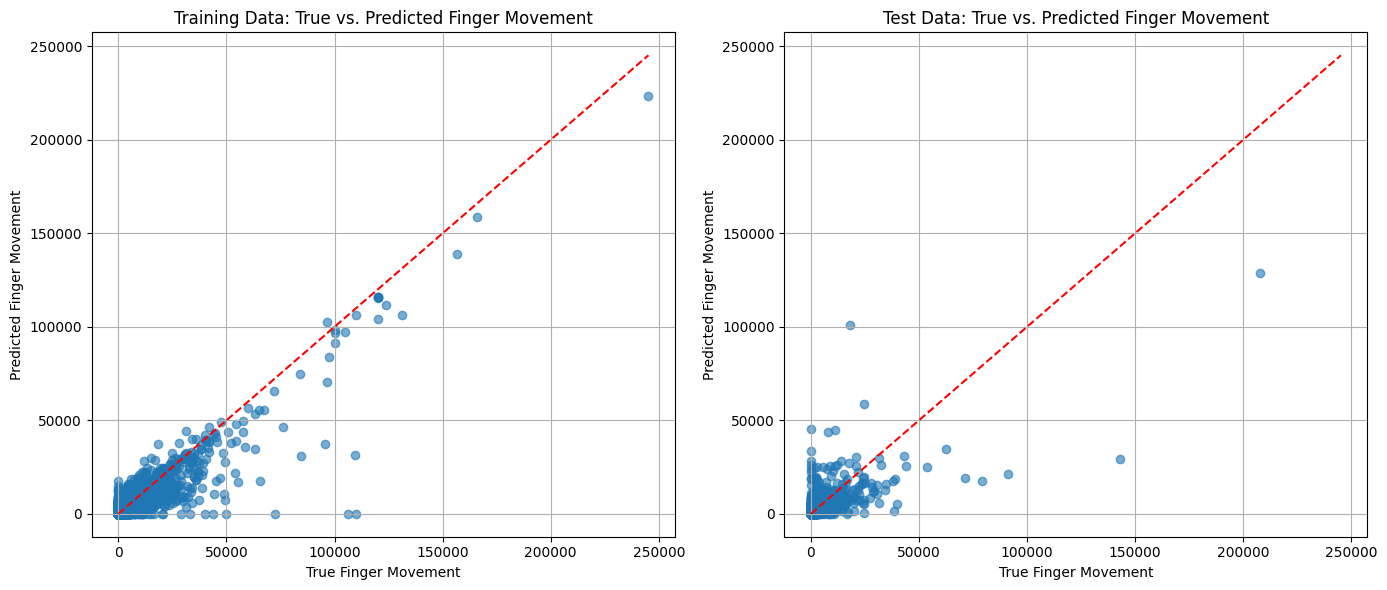

In [35]:
xgb = XGBRegressor(n_estimators=200, alphac=10, max_depth=5, learning_rate=0.1, random_state=RANDOM_STATE).fit(X_train, y_train)
evaluate(xgb)

## LightGBM

In [36]:
# lgbm = LGBMRegressor(random_state=RANDOM_STATE).fit(X_train, y_train)
# evaluate(lgbm)

## CatBoost

In [37]:
# cat = CatBoostRegressor(random_state=RANDOM_STATE).fit(X_train, y_train)
# evaluate(cat)

## Submission

In [38]:
X, y = data.drop(['Date', 'start_date', 'end_date', 'Month 4'], axis=1), data['Month 4']

months = [f'Month {i + 1}' for i in range(3)]

categorical = X.select_dtypes(include=['object']).columns.to_list()
continuous = X.drop(months, axis=1).select_dtypes(exclude=['object']).columns.to_list()

pipe1 = ColumnTransformer(
    [
        ('categorical', OneHotEncoder(sparse_output=True), categorical),
         ('continuous', StandardScaler(), continuous),
          ('months', RobustScaler(), months)
    ],
    sparse_threshold=0)

X = pipe1.fit_transform(X)

model = XGBRegressor(n_estimators=200, alphac=10, max_depth=5, learning_rate=0.1, random_state=RANDOM_STATE).fit(X, y)
pred = model.predict(X)
mean_squared_error(y, pred, squared=False)

303.7978969135932

In [39]:
data_submission = pd.read_csv('datasets_hi4/X_test.csv', delimiter=';')

In [40]:
# ADDITIONAL DATA
gscpi = pd.read_csv("datasets_hi4/extra-dataset/GSCPI_data.csv")
lpi = pd.read_csv("datasets_hi4/extra-dataset/LPIextend.csv")
world_bank_economics = pd.read_csv("datasets_hi4/extra-dataset/worldbank_economic_data.csv")
world_bank_inflation = pd.read_csv("datasets_hi4/extra-dataset/worldbank_inflation_data.csv")

data_submission['Cluster'].replace({"USA": "United States", 'Hong Kong & Macao': 'Hong Kong'}, inplace=True)
# data_submission = data_submission.rename(columns={'Country': 'Country_index'})

### adding gscpi data_submission to the main data_submissionframe
data_submission["Month 1_gscpi"] = ''
data_submission["Month 2_gscpi"] = ''
data_submission["Month 3_gscpi"] = ''
data_submission["Month 4_gscpi"] = ''

data_submission.loc[data_submission["Date"] == 'sep-dec 2020', "Month 1_gscpi"] = float(gscpi.loc[gscpi["Year-Month"]=="2020-09", "GSCPI"])
data_submission.loc[data_submission["Date"] == 'sep-dec 2020', "Month 2_gscpi"] = float(gscpi.loc[gscpi["Year-Month"]=="2020-10", "GSCPI"])
data_submission.loc[data_submission["Date"] == 'sep-dec 2020', "Month 3_gscpi"] = float(gscpi.loc[gscpi["Year-Month"]=="2020-11", "GSCPI"])
data_submission.loc[data_submission["Date"] == 'sep-dec 2020', "Month 4_gscpi"] = float(gscpi.loc[gscpi["Year-Month"]=="2020-12", "GSCPI"])

data_submission.loc[data_submission["Date"] == 'jan-apr 2021', "Month 1_gscpi"] = float(gscpi.loc[gscpi["Year-Month"]=="2021-01", "GSCPI"])
data_submission.loc[data_submission["Date"] == 'jan-apr 2021', "Month 2_gscpi"] = float(gscpi.loc[gscpi["Year-Month"]=="2021-02", "GSCPI"])
data_submission.loc[data_submission["Date"] == 'jan-apr 2021', "Month 3_gscpi"] = float(gscpi.loc[gscpi["Year-Month"]=="2021-03", "GSCPI"])
data_submission.loc[data_submission["Date"] == 'jan-apr 2021', "Month 4_gscpi"] = float(gscpi.loc[gscpi["Year-Month"]=="2021-04", "GSCPI"])

data_submission.loc[data_submission["Date"] == 'may-aug 2021', "Month 1_gscpi"] = float(gscpi.loc[gscpi["Year-Month"]=="2021-05", "GSCPI"])
data_submission.loc[data_submission["Date"] == 'may-aug 2021', "Month 2_gscpi"] = float(gscpi.loc[gscpi["Year-Month"]=="2021-06", "GSCPI"])
data_submission.loc[data_submission["Date"] == 'may-aug 2021', "Month 3_gscpi"] = float(gscpi.loc[gscpi["Year-Month"]=="2021-07", "GSCPI"])
data_submission.loc[data_submission["Date"] == 'may-aug 2021', "Month 4_gscpi"] = float(gscpi.loc[gscpi["Year-Month"]=="2021-08", "GSCPI"])

data_submission.loc[data_submission["Date"] == 'sep-dec 2021', "Month 1_gscpi"] = float(gscpi.loc[gscpi["Year-Month"]=="2021-09", "GSCPI"])
data_submission.loc[data_submission["Date"] == 'sep-dec 2021', "Month 2_gscpi"] = float(gscpi.loc[gscpi["Year-Month"]=="2021-10", "GSCPI"])
data_submission.loc[data_submission["Date"] == 'sep-dec 2021', "Month 3_gscpi"] = float(gscpi.loc[gscpi["Year-Month"]=="2021-11", "GSCPI"])
data_submission.loc[data_submission["Date"] == 'sep-dec 2021', "Month 4_gscpi"] = float(gscpi.loc[gscpi["Year-Month"]=="2021-12", "GSCPI"])

data_submission.loc[data_submission["Date"] == 'jan-apr 2022', "Month 1_gscpi"] = float(gscpi.loc[gscpi["Year-Month"]=="2022-01", "GSCPI"])
data_submission.loc[data_submission["Date"] == 'jan-apr 2022', "Month 2_gscpi"] = float(gscpi.loc[gscpi["Year-Month"]=="2022-02", "GSCPI"])
data_submission.loc[data_submission["Date"] == 'jan-apr 2022', "Month 3_gscpi"] = float(gscpi.loc[gscpi["Year-Month"]=="2022-03", "GSCPI"])
data_submission.loc[data_submission["Date"] == 'jan-apr 2022', "Month 4_gscpi"] = float(gscpi.loc[gscpi["Year-Month"]=="2022-04", "GSCPI"])

data_submission.loc[data_submission["Date"] == 'may-aug 2022', "Month 1_gscpi"] = float(gscpi.loc[gscpi["Year-Month"]=="2022-05", "GSCPI"])
data_submission.loc[data_submission["Date"] == 'may-aug 2022', "Month 2_gscpi"] = float(gscpi.loc[gscpi["Year-Month"]=="2022-06", "GSCPI"])
data_submission.loc[data_submission["Date"] == 'may-aug 2022', "Month 3_gscpi"] = float(gscpi.loc[gscpi["Year-Month"]=="2022-07", "GSCPI"])
data_submission.loc[data_submission["Date"] == 'may-aug 2022', "Month 4_gscpi"] = float(gscpi.loc[gscpi["Year-Month"]=="2022-08", "GSCPI"])

data_submission.loc[data_submission["Date"] == 'sep-dec 2022', "Month 1_gscpi"] = float(gscpi.loc[gscpi["Year-Month"]=="2022-09", "GSCPI"])
data_submission.loc[data_submission["Date"] == 'sep-dec 2022', "Month 2_gscpi"] = float(gscpi.loc[gscpi["Year-Month"]=="2022-10", "GSCPI"])
data_submission.loc[data_submission["Date"] == 'sep-dec 2022', "Month 3_gscpi"] = float(gscpi.loc[gscpi["Year-Month"]=="2022-11", "GSCPI"])
data_submission.loc[data_submission["Date"] == 'sep-dec 2022', "Month 4_gscpi"] = float(gscpi.loc[gscpi["Year-Month"]=="2022-12", "GSCPI"])

data_submission.loc[data_submission["Date"] == 'jan-apr 2023', "Month 1_gscpi"] = float(gscpi.loc[gscpi["Year-Month"]=="2023-01", "GSCPI"])
data_submission.loc[data_submission["Date"] == 'jan-apr 2023', "Month 2_gscpi"] = float(gscpi.loc[gscpi["Year-Month"]=="2023-02", "GSCPI"])
data_submission.loc[data_submission["Date"] == 'jan-apr 2023', "Month 3_gscpi"] = float(gscpi.loc[gscpi["Year-Month"]=="2023-03", "GSCPI"])
data_submission.loc[data_submission["Date"] == 'jan-apr 2023', "Month 4_gscpi"] = float(gscpi.loc[gscpi["Year-Month"]=="2023-04", "GSCPI"])

data_submission.loc[data_submission["Date"] == 'may-jul 2023', "Month 1_gscpi"] = float(gscpi.loc[gscpi["Year-Month"]=="2023-05", "GSCPI"])
data_submission.loc[data_submission["Date"] == 'may-jul 2023', "Month 2_gscpi"] = float(gscpi.loc[gscpi["Year-Month"]=="2023-06", "GSCPI"])
data_submission.loc[data_submission["Date"] == 'may-jul 2023', "Month 3_gscpi"] = float(gscpi.loc[gscpi["Year-Month"]=="2023-07", "GSCPI"])

###  adding LPIextend data_submission to the main data_submissionset
lpi = lpi[["Country", "population (2023)", "area", 'landAreaKm', 'unMember', 'growthRate', 'worldPercentage',
          "density"]]
data_submission = data_submission.merge(lpi, how='left', left_on="Cluster", right_on="Country")

###   adding world_bank_economic data_submission to the main data_submissionset
world_bank_economics = world_bank_economics[["Country", "Year", "Agriculture, forestry, and fishing, value added (annual % growth)",
                                            'Exports of goods and services (annual % growth)',
                                            'Final consumption expenditure (annual % growth)',
                                            'GDP (current US$)',
                                            'Gross capital formation (annual % growth)',
                                            'Imports of goods and services (annual % growth)',
                                            'Industry (including construction), value added (annual % growth)']]

world_bank_economics['Agriculture, forestry, and fishing, value added (annual % growth)'] = world_bank_economics.groupby('Country')['Agriculture, forestry, and fishing, value added (annual % growth)'].apply(lambda x: x.mask(world_bank_economics['Year'] == 2023, x[world_bank_economics['Year'] == 2022].values))
world_bank_economics['Exports of goods and services (annual % growth)'] = world_bank_economics.groupby('Country')['Exports of goods and services (annual % growth)'].apply(lambda x: x.mask(world_bank_economics['Year'] == 2023, x[world_bank_economics['Year'] == 2022].values))
world_bank_economics['Final consumption expenditure (annual % growth)'] = world_bank_economics.groupby('Country')['Final consumption expenditure (annual % growth)'].apply(lambda x: x.mask(world_bank_economics['Year'] == 2023, x[world_bank_economics['Year'] == 2022].values))
world_bank_economics['GDP (current US$)'] = world_bank_economics.groupby('Country')['GDP (current US$)'].apply(lambda x: x.mask(world_bank_economics['Year'] == 2023, x[world_bank_economics['Year'] == 2022].values))
world_bank_economics['Gross capital formation (annual % growth)'] = world_bank_economics.groupby('Country')['Gross capital formation (annual % growth)'].apply(lambda x: x.mask(world_bank_economics['Year'] == 2023, x[world_bank_economics['Year'] == 2022].values))
world_bank_economics['Imports of goods and services (annual % growth)'] = world_bank_economics.groupby('Country')['Imports of goods and services (annual % growth)'].apply(lambda x: x.mask(world_bank_economics['Year'] == 2023, x[world_bank_economics['Year'] == 2022].values))
world_bank_economics['Industry (including construction), value added (annual % growth)'] = world_bank_economics.groupby('Country')['Industry (including construction), value added (annual % growth)'].apply(lambda x: x.mask(world_bank_economics['Year'] == 2023, x[world_bank_economics['Year'] == 2022].values))


data_submission['Year'] = data_submission['Date'].str.extract(r'(\d{4})')

data_submission = data_submission.rename(columns={'Cluster': 'Country'})

data_submission['Year'] = data_submission['Year'].astype(int)

data_submission = pd.merge(data_submission, world_bank_economics, how='left', on=['Country', 'Year'])

###  adding world bank inflation to the main data_submission frame
###  we only keep some months (one month per period date) and we do the equivalence with the appropriate
###  date
world_bank_inflation = world_bank_inflation.loc[(world_bank_inflation["Year-Month"] == "2020-11") |
                                                (world_bank_inflation["Year-Month"] == "2023-03") |
                                                (world_bank_inflation["Year-Month"] == "2021-07") |
                                                (world_bank_inflation["Year-Month"] == "2022-03") |
                                                (world_bank_inflation["Year-Month"] == "2021-11") |
                                                (world_bank_inflation["Year-Month"] == "2021-03") |
                                                (world_bank_inflation["Year-Month"] == "2022-11") |
                                                (world_bank_inflation["Year-Month"] == "2022-07") |
                                                (world_bank_inflation["Year-Month"] == "2023-06")]

world_bank_inflation.loc[world_bank_inflation["Year-Month"] == "2020-11", "Year-Month"] = "sep-dec 2020"
world_bank_inflation.loc[world_bank_inflation["Year-Month"] == "2023-03", "Year-Month"] = "jan-apr 2023"
world_bank_inflation.loc[world_bank_inflation["Year-Month"] == "2021-07", "Year-Month"] = "may-aug 2021"
world_bank_inflation.loc[world_bank_inflation["Year-Month"] == "2022-03", "Year-Month"] = "jan-apr 2022"
world_bank_inflation.loc[world_bank_inflation["Year-Month"] == "2021-11", "Year-Month"] = "sep-dec 2021"
world_bank_inflation.loc[world_bank_inflation["Year-Month"] == "2021-03", "Year-Month"] = "jan-apr 2021"
world_bank_inflation.loc[world_bank_inflation["Year-Month"] == "2022-11", "Year-Month"] = "sep-dec 2022"
world_bank_inflation.loc[world_bank_inflation["Year-Month"] == "2022-07", "Year-Month"] = "may-aug 2022"
world_bank_inflation.loc[world_bank_inflation["Year-Month"] == "2023-06", "Year-Month"] = "may-jul 2023"

world_bank_inflation = world_bank_inflation.rename(columns={'Year-Month': 'Date'})

data_submission = pd.merge(data_submission, world_bank_inflation, how='left', on=['Country', 'Date'])

In [41]:
data_submission["Month 1"] = data_submission["Month 1"].apply(lambda x: int(x.replace(" ","")) if isinstance(x, str) else x)
data_submission["Month 2"] = data_submission["Month 2"].apply(lambda x: x.replace(" ","")).astype(int)
data_submission["Month 3"] = data_submission["Month 3"].apply(lambda x: x.replace(" ","")).astype(int)

In [42]:
# data_submission['Month 1'] = data_submission.apply(fill_month1_with_closest_month, axis=1)
# data_submission['Month 1'] = data_submission['Month 1'].astype(int)

In [43]:
data_submission['start_date'] = data_submission['Date'].apply(lambda x : x.split("-")[0])
data_submission['end_date'] = data_submission['Date'].apply(lambda x : x.split("-")[1][:3])
data_submission['year'] = data_submission["Date"].apply(lambda x: int(x.split(" ")[1]))

In [44]:
data_submission['Period'] = data_submission['start_date'].apply(assign_period)

In [45]:
data_submission["Product Life cycel status"].fillna("Active",inplace=True)
data_submission['Customer Persona proxy'] = data_submission['Customer Persona proxy'].apply(lambda x: x.replace("Customer Segmentation-", ""))
data_submission['Product  Line proxy'] = data_submission['Product  Line proxy'].apply(lambda x: x.replace("Product Line-", ""))
data_submission['Reference proxy'] = data_submission['Reference proxy'].apply(lambda x: x.replace("reference-", ""))
data_submission['Division proxy'] = data_submission['Division proxy'].apply(lambda x: x.replace("Division-", ""))
data_submission['Strategic Product Family proxy'] = data_submission['Strategic Product Family proxy'].apply(lambda x: x.replace("Strategic Product Family-", ""))
# data_submission['Trend 1'] = data_submission['Month 2'] - data_submission['Month 1']
# data_submission['Trend 2'] = data_submission['Month 3'] - data_submission['Month 2']

In [46]:
data_submission['Trend 1'] = compute_trend(data_submission['Month 1'], data_submission['Month 2'])
data_submission['Trend 2'] = compute_trend(data_submission['Month 2'], data_submission['Month 3'])

In [47]:
# Additional data
data_submission['unMember'].fillna(mode_unMember, inplace=True)
data_submission['unMember'] = data_submission['unMember'].astype(int)
data_submission['Month 1_gscpi'] = pd.to_numeric(data_submission['Month 1_gscpi'])
data_submission['Month 2_gscpi'] = pd.to_numeric(data_submission['Month 2_gscpi'])
data_submission['Month 3_gscpi'] = pd.to_numeric(data_submission['Month 3_gscpi'])
data_submission['Month 4_gscpi'] = pd.to_numeric(data_submission['Month 4_gscpi'])

In [48]:
# columns_with_na = data_submission.columns[data_submission.isna().any()].tolist()

# for col in tqdm(columns_with_na):
#     data_submission[col] = data_submission[col].fillna(median[col])

In [49]:
for col in columns_to_impute:
    if col in data_submission.columns:
        data_submission[col] = imputer[col].transform(data_submission[col].values.reshape(-1, 1))

In [50]:
data_submission.isna().sum() / len(data_submission)

index                                                                0.000000
id_product                                                           0.000000
Region                                                               0.000000
Country_x                                                            0.000000
Site                                                                 0.000000
Operations                                                           0.000000
Zone                                                                 0.000000
Country                                                              0.000000
Reference proxy                                                      0.000000
Product  Line proxy                                                  0.000000
Division proxy                                                       0.000000
Customer Persona proxy                                               0.000000
Strategic Product Family proxy                                  

In [51]:
X_sub_index = data_submission['index']
data_submission.drop(['index', 'id_product', 'Country', 'Region', 'Site', 'Reference proxy'], axis=1, inplace =True)

In [52]:
X_sub = pipe1.transform(data_submission)

In [54]:
### USE THE RIGHT MODEL HERE
y_pred = model.predict(X_sub)
y_pred = np.maximum(y_pred, 0)

In [55]:
submission = pd.DataFrame({'index': X_sub_index, 'Month 4': y_pred})
submission

,index,Month 4
0,490548,6355.229492
1,2167957,1.685212
2,1999013,2.662157
3,469221,102.299965
4,1171716,1.075302
...,...,...
440738,849490,1.075302
440739,1199858,2.020471
440740,1007643,1.239462
440741,1647728,1.075302


In [56]:
submission.to_csv('hackathon_team_17.csv', sep=';', index=False)